### **Installation**

In [ ]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


### **Libraries**

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer
import numpy as np
from numpy.random import sample
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import jax
import matplotlib as mpl
from sklearn import datasets
import seaborn as sns
import pandas as pd
from keras.utils import to_categorical

from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax
import pandas as pd

sns.set()

seed = 0
rng = np.random.default_rng(seed=seed)

### **Convolution & Pooling layer**

In [ ]:
def conv_layer(weights,wires,skip_first_conv_layer=True):
  n_wires = len(wires)
  for l in [0,1]:
    for i,w in enumerate(wires):
      if i%2 == l and i < n_wires-1:
        if i%2 == 0 and not skip_first_conv_layer:
          qml.U3(*weights[:3],wires=wires[i])
          qml.U3(*weights[3:6],wires=[wires[i+1]])
        qml.CNOT(wires=[wires[i],wires[i+1]])
        qml.RY(weights[6],wires=[wires[i]])
        qml.RZ(weights[7],wires=[wires[i+1]])
        qml.CNOT(wires=[wires[i+1],wires[i]])
        qml.RY(weights[8],wires=[wires[i]])
        qml.CNOT(wires=[wires[i],wires[i+1]])
        qml.U3(*weights[9:12],wires=[wires[i]])
        qml.U3(*weights[12:],wires=[wires[i+1]])

In [ ]:
def pool_layer(weights,wires):
  n_wires = len(wires)
  for i,w in enumerate(wires):
    if i%2 == 0 and i < n_wires-1:
      qml.CRZ(weights[0],wires=[wires[i],wires[i+1]])
      qml.PauliX(wires=wires[i])
      qml.CRX(weights[1],wires=[wires[i],wires[i+1]])

In [ ]:
def qc_layer(weights,wires,skip_first_conv_layer=True,skip_pool=True):
  conv_layer(weights[:15],wires,skip_first_conv_layer=skip_first_conv_layer)
  if skip_pool != True:
    pool_layer(weights[15:],wires)

def dense_layer(weights,wires):
  qml.ArbitraryUnitary(weights,wires)

### **Quantum Convolution Neural Network**

In [ ]:
num_wires = 6
dev = qml.device("default.qubit",wires = num_wires)
@qml.qnode(dev,interface = 'jax')
def qcnn(weights,weights_dense,features):
    layer = weights.shape[1]
    wires = list(range(num_wires))

    # inputs the state input_state
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layer):
        qc_layer(weights[:, j], wires,skip_first_conv_layer=(not j==0),skip_pool=False)
        wires = wires[1::2]
        qml.Barrier(wires=wires, only_visual=True)

    assert weights_dense.size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!"
        f" \n Expected {4 ** (len(wires)) - 1}, Given {weights_dense.size}"
    )
    dense_layer(weights_dense, wires)
    return qml.probs(wires=wires[-1])

### **Trial Model Circuit**

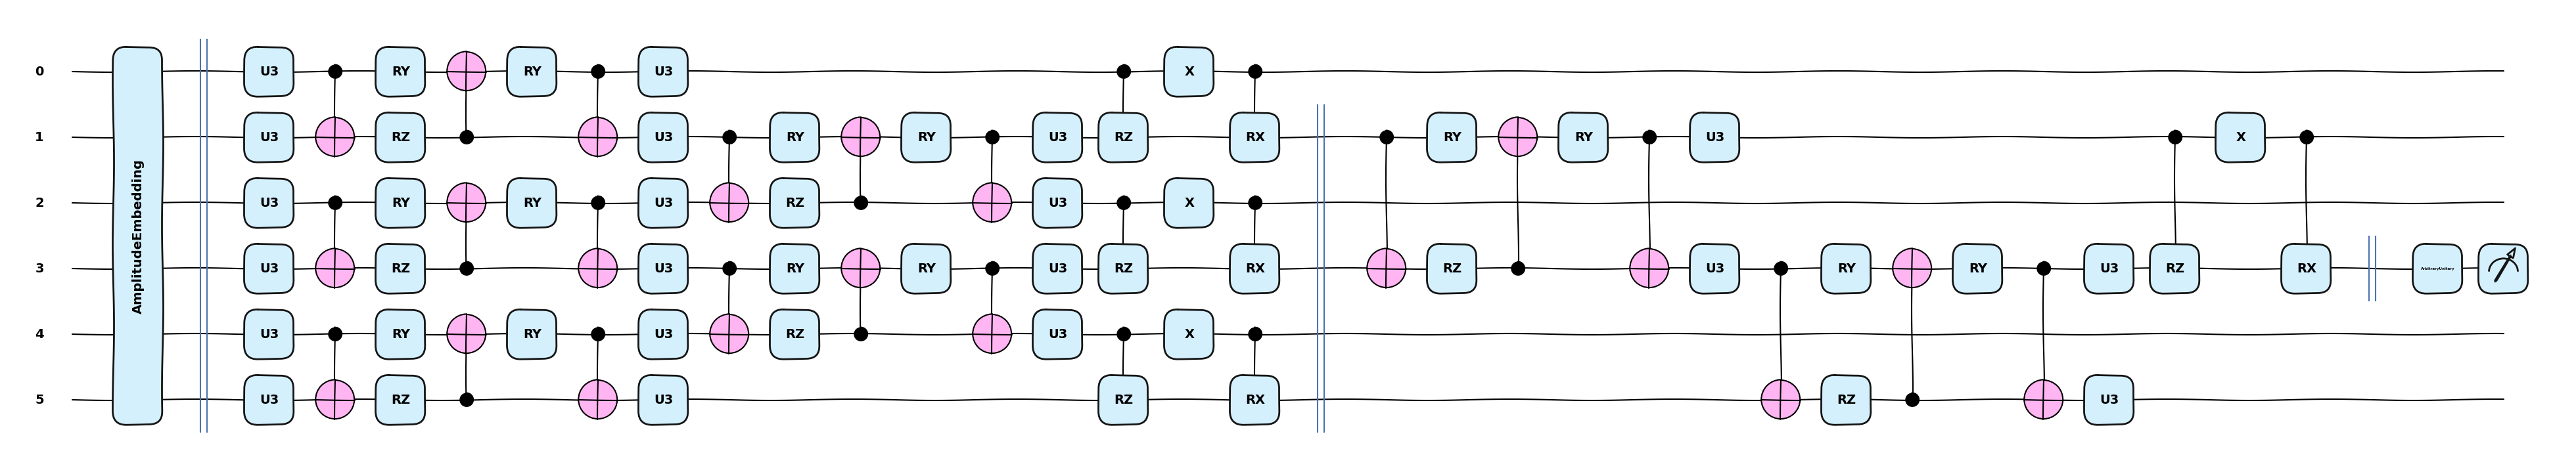

In [ ]:
ip = np.random.rand(17, 2), np.random.rand(3), np.random.rand(2 ** num_wires)
fig, ax = qml.draw_mpl(qcnn,style='pennylane')(*ip)
plt.show()

In [ ]:
np.argmax(qcnn(*ip)*100 > 50)

Array(1, dtype=int64)

### **Training QCNN - Binary digits**

Loading of the dataset

In [ ]:
def load_digits_data(num_train, num_test, rng):
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    features, labels = digits.data, digits.target

    # only use first two classes
    features = features[np.where((labels == 0)|(labels == 1))]
    labels = labels[np.where((labels == 0)|(labels == 1))]

    # features = features[np.where((labels == 0) |(labels==1))]
    # labels = labels[np.where((labels == 0) |(labels==1))]
    # # normalize data
    features = features / np.linalg.norm(features, axis=1).reshape((-1, 1))

    # subsample train and test split
    train_indices = rng.choice(len(labels), num_train, replace=False)
    test_indices = rng.choice(
        np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
    )

    x_train, y_train = features[train_indices], labels[train_indices]
    x_test, y_test = features[test_indices], labels[test_indices]
    # y_train = to_categorical(y_train)
    # y_test = to_categorical(y_test)

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )

In [ ]:
@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: qcnn(weights, weights_last, feature)[
        label
    ]
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return jnp.sum(out > 0.5) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return 1.0 - jnp.sum(out) / len(labels)


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(17, 2), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 1 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

In [ ]:
def train_qcnn(n_train, n_test, n_epochs):
    """
    Args:
        n_train  (int): number of training examples
        n_test   (int): number of test examples
        n_epochs (int): number of training epochs
        desc  (string): displayed string during optimization

    Returns:
        dict: n_train,
        steps,
        train_cost_epochs,
        train_acc_epochs,
        test_cost_epochs,
        test_acc_epochs

    """
    # load data
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test, rng)

    # init weights and optimizer
    weights, weights_last = init_weights()

    # learning rate decay
    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adamw(learning_rate=cosine_decay_scheduler)
    opt_state = optimizer.init((weights, weights_last))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        # Training step with (adam) optimizer
        train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        weights, weights_last = optax.apply_updates((weights, weights_last), updates)

        train_cost_epochs.append(train_cost)

        # compute accuracy on training data
        train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
        train_acc_epochs.append(train_acc)

        # compute accuracy and cost on testing data
        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_acc = jnp.sum(test_out > 0.5) / len(test_out)
        test_acc_epochs.append(test_acc)
        test_cost = 1.0 - jnp.sum(test_out) / len(test_out)
        test_cost_epochs.append(test_cost)

    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )

In [ ]:
n_test = 100
n_epochs = 100
n_reps = 1


def run_iterations(n_train):
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )
    for _ in range(n_reps):
        results = train_qcnn(n_train=n_train, n_test=n_test, n_epochs=n_epochs)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df


# run training for multiple sizes
train_sizes = [100]
results_df = run_iterations(n_train=100)
# for n_train in train_sizes[1:]:
#     results_df = pd.concat([results_df, run_iterations(n_train=n_train)])

ValueError: ignored

In [ ]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # # plot final loss difference
    # dif = df[df.step == 100].test_cost["mean"] - df[df.step == 100].train_cost["mean"]
    # generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# # format generalization error plot
# ax = axes[1]
# ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
# ax.set_xscale('log')
# ax.set_xticks(train_sizes)
# ax.set_xticklabels(train_sizes)
# ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
# ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
# ax.set_ylim(0.5, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

# axes[1].set_yscale('log', base=2)
plt.show()

In [ ]:
df.train_acc['mean'][n_epochs-1], df.test_acc['mean'][n_epochs-1]

### **CNN - Binary digits**

In [ ]:
def load_digits_data_cnn():
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    # dat = sample(digits,n)
    features, labels = digits.data, digits.target

    # only use first two classes
    features = features[np.where((labels == 0) | (labels == 1))]
    labels = labels[np.where((labels == 0) | (labels ==1))]

    x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.4,random_state=2)
    scaler = MinMaxScaler(feature_range = (0, 1))
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    return (x_train,x_test,y_train,y_test)

In [ ]:
def cnn_model():
  layer1 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same',input_shape=([8,8,1]))
  layer2 = layers.MaxPool2D((2,2))

  layer3 = layers.Conv2D(64,kernel_size=2,activation='relu',padding='same')
  layer4 = layers.MaxPool2D((2,2))

  # layer5 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer6 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer7 = layers.MaxPool2D((2,2))

  layer8 = layers.Flatten()
  layer9 = layers.Dense(6,activation='relu')
  layer10 = layers.Dropout(0.3)
  layer11 = layers.Dense(2,activation = 'sigmoid')
  # ,layer5,layer6,layer7
  model = keras.Sequential([layer1,layer2,layer3,layer4,layer8,layer9,layer10,layer11])
  return model

In [ ]:
model = cnn_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.1,epsilon=0.01)
model.compile(optimizer = opt, loss='categorical_crossentropy',
             metrics=["accuracy"])

In [ ]:
x_train,x_test,y_train,y_test = load_digits_data_cnn()

# Drop the label and reshape the rest
X_train = x_train.reshape(len(x_train), 8, 8, 1)
# Reshape the label
Y_train = y_train.reshape(len(y_train),1)
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_test = x_test.reshape(len(x_test), 8, 8, 1)
Y_test = y_test.reshape(len(y_test), 1)

In [ ]:
history = model.fit(x=X_train,y=to_categorical(Y_train), validation_data = (X_test,to_categorical(Y_test)),epochs=100,batch_size=100,verbose=None)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          8256      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                

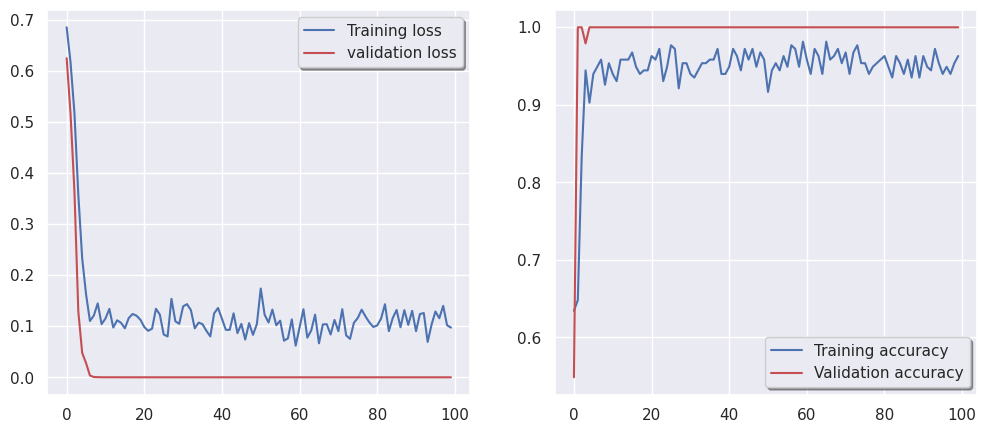

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
max(history.history['accuracy']),max(history.history['val_accuracy'])

(0.9814814925193787, 1.0)

(array([0, 1]), array([105, 111]))

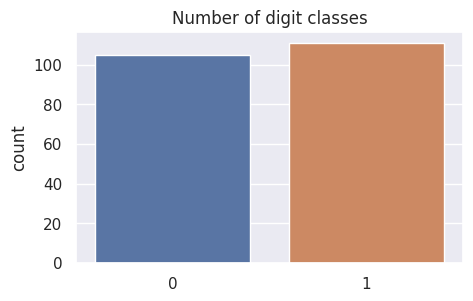

In [ ]:
plt.figure(figsize=(5,3))
sns.countplot(x=y_train)
plt.title("Number of digit classes");
np.unique(y_train,return_counts=True)

In [ ]:
def run_iterations(n_reps,n_epochs):

    results_df = pd.DataFrame(
        columns=["loss", "accuracy", "val_loss", "val_accuracy"])
    # results_df = pd.DataFrame(
    #     columns=["loss", "binary_accuracy", "val_loss", "val_binary_accuracy"]
    # )
    for _ in range(n_reps):

        result = model.fit(x=X_train,y=to_categorical(Y_train), validation_data = (X_test,to_categorical(Y_test)),epochs=n_epochs,batch_size=100,verbose=None)
        results = pd.DataFrame(result.history)
        results_df = pd.concat(
            [results_df,results], axis=0, ignore_index=True
        )
    return results_df

In [ ]:
steps = []
for _ in range(1):
  step = np.arange(1,101,1)
  steps.append(step)


steps = np.array(steps)
steps = steps.reshape(100,-1)
# steps = pd.DataFrame(steps,columns=['steps'])


In [ ]:
results = run_iterations(1,100)

In [ ]:
results

,loss,accuracy,val_loss,val_accuracy
0,0.800882,0.723562,0.494607,0.899861
1,0.892267,0.696660,0.528888,0.899861
2,0.763845,0.761596,0.746603,0.856745
3,0.754961,0.756957,0.562114,0.869263
4,0.824482,0.708720,0.662905,0.888734
...,...,...,...,...
95,0.812373,0.754174,0.842307,0.872045
96,0.823897,0.753247,0.771408,0.887344
97,0.709039,0.786642,0.648981,0.891516
98,0.820903,0.749536,0.916282,0.883171


In [ ]:
results['steps'] = steps

In [ ]:
df_ag = results.groupby(['steps']).agg(["mean", "std"])
df_ag = df_ag.reset_index()

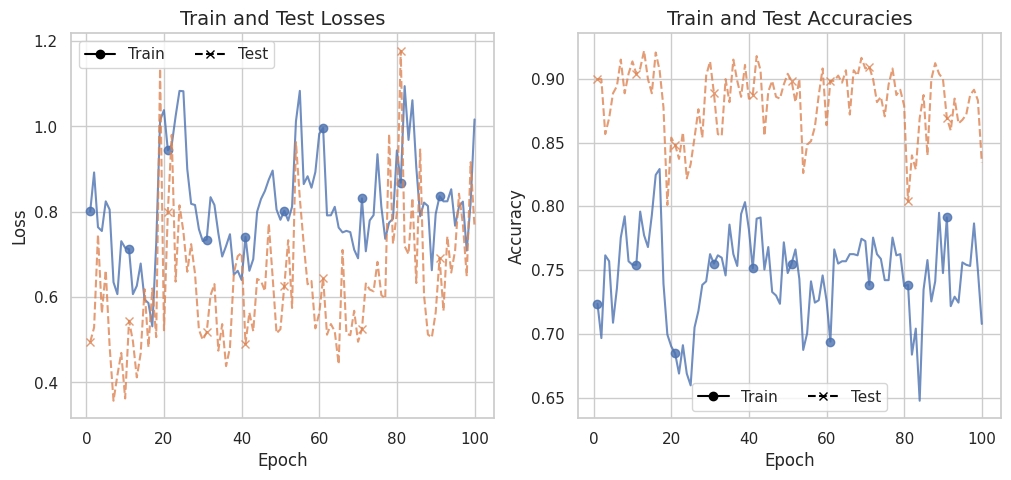

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
sns.set_style('whitegrid')
colors = sns.color_palette()
df1 = [df_ag.loss["mean"], df_ag.val_loss["mean"], df_ag.accuracy["mean"], df_ag.val_accuracy["mean"]]
lines = ["o-", "x--", "o-", "x--"]
labels = ['loss', 'test_loss', 'train_accuracy', 'test_accuracy']
axs = [0,0,1,1]

for k in range(4):
  ax = axes[axs[k]]
  ax.plot(df_ag.steps, df1[k], lines[k], label=labels[k], markevery=10, alpha=0.8)

ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
# ax.set_ylim(0.5, 1.05)

legend_elements =  [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

In [ ]:
df_ag.binary_accuracy.max(),df_ag.val_binary_accuracy.max()

AttributeError: ignored

In [ ]:
df_agg

In [ ]:
# idx = np.random.randint(0, len(x_train))
# image = x_train[idx,:]
# plt.imshow(image)
# plt.show()

In [ ]:
# train_datagen = ImageDataGenerator(rotation_range = 10,  # rotation
#                                    width_shift_range = 0.1,  # horizontal shift
#                                    height_shift_range = 0.1,
#                                    zoom_range = 0.1) # zoom

In [ ]:
# monitor_val_loss = keras.callbacks.EarlyStopping(monitor = "val_loss",
#                                  min_delta = 1e-3,
#                                  patience = 5, # Wait 5 more epochs
#                                  verbose = 1,
#                                  mode = "auto",
#                                  restore_best_weights = True)

In [ ]:
num_wires = 6
dev = qml.device("default.qubit",wires = num_wires)
@qml.qnode(dev,interface = 'tf')
def hqcnn(inputs,weights):
    layer = weights.shape[1]
    wires = list(range(num_wires))

    # inputs the state input_state
    qml.AngleEmbedding(features=inputs, wires=wires)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layer):
        qc_layer(weights[:, j], wires,skip_first_conv_layer=(not j==0),skip_pool=(not j==1) )
        wires = wires[0::2]
        qml.Barrier(wires=wires, only_visual=True)

    # assert weights_dense.size == 4 ** (len(wires)) - 1, (
    #     "The size of the last layer weights vector is incorrect!"
    #     f" \n Expected {4 ** (len(wires)) - 1}, Given {weights_dense.size}"
    # )
    # dense_layer(weights_dense, wires)
    return qml.probs(wires=wires)

In [ ]:
weight_shapes = {"weights": (17,1)}
n_qubits = 6

In [ ]:
qlayer = qml.qnn.KerasLayer(hqcnn, weight_shapes, output_dim=n_qubits)

In [ ]:
def hqcnn_model():
  layer1 = layers.Conv2D(32,kernel_size=2,activation='relu',padding='same')
  layer2 = layers.MaxPool2D((2,2))

  layer3 = layers.Conv2D(64,kernel_size=2,activation='relu',padding='same')
  layer4 = layers.MaxPool2D((2,2))

  # layer5 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer6 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer7 = layers.MaxPool2D((2,2))

  layer8 = layers.Flatten()
  layer9 = layers.Dense(6,activation='relu')
  layer10 = layers.Dropout(0.3)
  layer11 = layers.Dense(2,activation = 'sigmoid')
  # ,layer5,layer6,layer7
  #,layer1,layer2,layer3,layer4,layer8
  model = keras.Sequential([layer9,qlayer,layer10,layer11])
  return model

In [ ]:
model = hqcnn_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.1,epsilon=0.01)
model.compile(optimizer = opt, loss='categorical_crossentropy',
             metrics=["accuracy"])

In [ ]:
qml.math.shape(x_train)

(216, 64)

In [ ]:
qml.math.ndim(x_train) >1

True

In [ ]:
qml.math.get_interface(x_train)

'numpy'

In [ ]:
x_train,x_test,y_train,y_test = load_digits_data_cnn()

# Drop the label and reshape the rest
X_train = x_train.reshape(len(x_train), 8, 8, 1)
# Reshape the label
Y_train = y_train.reshape(len(y_train),1)
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_test = x_test.reshape(len(x_test), 8, 8, 1)
Y_test = y_test.reshape(len(y_test), 1)

In [ ]:
history = model.fit(x=x_train,y=to_categorical(y_train), validation_data = (x_test,to_categorical(y_test)),epochs=50,batch_size=32,verbose=None)

ValueError: ignored

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def load_iris_data(n_train,n_test,rng):

  # import some data to play with
  iris = datasets.load_iris()
  X = iris.data  # we only take the first two features.
  Y = iris.target

  x_train, x_test, trainy, testy = train_test_split(X, Y, test_size=n_test/(n_train+n_test), random_state=42)

  trainyh = tf.one_hot(trainy, depth=4)
  testyh = tf.one_hot(testy, depth=4)
  return (
        jnp.asarray(x_train),
        jnp.asarray(trainyh),
        jnp.asarray(x_test),
        jnp.asarray(testyh),
    )

In [ ]:
@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: qcnn(weights, weights_last, feature)[
        label
    ]
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return jnp.sum(out > 0.5) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return 1.0 - jnp.sum(out) / len(labels)


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(17, 1), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 1 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

In [ ]:
def train_qcnn_iris(n_train, n_test, n_epochs):
    """
    Args:
        n_train  (int): number of training examples
        n_test   (int): number of test examples
        n_epochs (int): number of training epochs
        desc  (string): displayed string during optimization

    Returns:
        dict: n_train,
        steps,
        train_cost_epochs,
        train_acc_epochs,
        test_cost_epochs,
        test_acc_epochs

    """
    # load data
    x_train, y_train, x_test, y_test = load_iris_data(n_train, n_test, rng)

    # init weights and optimizer
    weights, weights_last = init_weights()

    # learning rate decay
    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adam(learning_rate=cosine_decay_scheduler)
    opt_state = optimizer.init((weights, weights_last))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        # Training step with (adam) optimizer
        train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        weights, weights_last = optax.apply_updates((weights, weights_last), updates)

        train_cost_epochs.append(train_cost)

        # compute accuracy on training data
        train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
        train_acc_epochs.append(train_acc)

        # compute accuracy and cost on testing data
        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_acc = jnp.sum(test_out > 0.5) / len(test_out)
        test_acc_epochs.append(test_acc)
        test_cost = 1.0 - jnp.sum(test_out) / len(test_out)
        test_cost_epochs.append(test_cost)

    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )

In [ ]:
# n_test = 100
n_epochs = 100
n_reps = 100


def run_iterations(num):
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_qcnn_iris(n_train=0.7*num, n_test=0.3*num, n_epochs=n_epochs)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df


# run training for multiple sizes
# train_sizes = [2, 5, 10, 20, 40, 80]
# results_df = run_iterations(n_train=2)
# for n_train in train_sizes[1:]:
#     results_df = pd.concat([results_df, run_iterations(n_train=n_train)])

In [ ]:
results_df = run_iterations(num=150)

TypeError: ignored

In [ ]:
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
# df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=3, figsize=(16.5, 5))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,2,2]

    for k in range(1):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    dif = df[df.step == 100].test_cost["mean"] - df[df.step == 100].train_cost["mean"]
    generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
ax = axes[1]
ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
ax.set_xscale('log')
ax.set_xticks(train_sizes)
ax.set_xticklabels(train_sizes)
ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[2]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[2].legend(handles=legend_elements, ncol=3)

axes[1].set_yscale('log', base=2)
plt.show()